<a href="https://colab.research.google.com/github/ranggakd/DAIly/blob/main/ideas/regression_forecasting_metrics/Metrics_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ranggakd/DAIly/blob/main/ideas/helpful_rating_system/Goodbye_Average_Rating_System_Hello_Helpful_Rating_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![Open Medium](https://gist.githubusercontent.com/ranggakd/34926ba72fa0b0c17566b0b2a52296de/raw/90dde15647e4d3e6d292f2a95612cb3bd428dcf3/medium.svg)](https://medium.com/@ranggakd/rating-system-is-not-credible-anymore-so-i-propose-a-new-one-24d4b5926702)
[![Open Dev](https://gist.githubusercontent.com/ranggakd/e570f46b5517f90e8102c6a227b64247/raw/cce6e2068d988a06b00c1b3d6f92644a8218d0d6/dev_to.svg)](https://dev.to/ranggakd/beyond-stars-the-helpful-rating-system-outshines-traditional-5-star-reviews-4ahe)

This notebook is Google Colab compatible. More explanation available on Medium or dev.to.

In [2]:
#@markdown *Last running requirement version*

!python -V

# uncomment line below if you are using Linux or Google Colab
!pip freeze | grep -w 'pandas'
!pip freeze | grep -w 'numpy'
!pip freeze | grep -w 'matplotlib'
!pip freeze | grep -w 'statsmodels'
!pip freeze | grep -w 'scikit-learn'
!pip freeze | grep -w 'plotly'

# uncomment line below if you are using Windows
# !pip freeze | findstr /C:"pandas"
# !pip freeze | findstr /C:"numpy"
# !pip freeze | findstr /C:"matplotlib"
# !pip freeze | findstr /C:"statsmodels"
# !pip freeze | findstr /C:"scikit-learn"
# !pip freeze | findstr /C:"plotly"

Python 3.10.12
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.17.9
sklearn-pandas==2.2.0
numpy==1.23.5
matplotlib==3.7.1
matplotlib-inline==0.1.6
matplotlib-venn==0.11.9
statsmodels==0.14.0
scikit-learn==1.2.2
plotly==5.15.0


disclamer

These results are may be biased from syntetic dataset and model and pretty much experimental

If your goal is to explore how a basic, yet reasonably good forecast model behaves across different metrics, then the `AutoReg` model from `statsmodels` is a suitable choice for this exploration. Its basic form with a single lag might be a bit more sophisticated than the Persistence Model, but it provides a good balance between simplicity and capability. Given that you're more focused on understanding metric behavior rather than achieving the best forecast accuracy, it's an appropriate choice.

Here's a rundown of why it works for your purpose:

1. **Simplicity with Capability**: `AutoReg`, especially with a single lag or a few lags, is not overly complicated. It captures some memory of the series but doesn't delve deep into more complex structures or seasonality without explicitly being told to do so (via lags).

2. **Diverse Behavior**: Since `AutoReg` does have parameters (like lags) that can be adjusted, it offers a range of behaviors in its predictions, which will be interesting when studying metric responses.

3. **Transparent Mechanism**: `AutoReg` is essentially a linear model that uses past values as predictors. This transparency is useful when you want to understand why certain metric values might be high or low.

## Import libraries

In [3]:
# Assuming this is in a Jupyter notebook environment due to the use of magic commands

try:
    import pandas as pd
except ImportError as e:
    print(e)
    %pip install pandas

try:
    import numpy as np
except ImportError as e:
    print(e)
    %pip install numpy

try:
    import matplotlib.pyplot as plt
except ImportError as e:
    print(e)
    %pip install matplotlib

try:
    from statsmodels.tsa.ar_model import AutoReg
except ImportError as e:
    print(e)
    %pip install statsmodels

try:
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import mean_absolute_percentage_error as mape
except ImportError as e:
    print(e)
    %pip install scikit-learn

try:
    from plotly import graph_objects as go
except ImportError as e:
    print(e)
    %pip install plotly

In [4]:
import random
from os.path import exists
from os import makedirs
from typing import Union
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from plotly import graph_objects as go

# xkcd-styled & humor sans font installed to give semi-sarcasm graph
plt.xkcd()
%matplotlib inline

### Constants

In [5]:
# constants
PLOT_DIR = 'plots'
R2 = 'r2'
MAE = 'mae'
MSE = 'mse'
RMSE = 'rmse'
MASE = 'mase'
MAPE = 'mape'
SMAPE = 'smape'
MBD = 'mbd'
HUNDRED_PERCENTAGE = 100
PERFECT_THRESHOLD = 0
ACCEPTABLE_THRESHOLD = .05
MODERATE_THRESHOLD = .1
HIGH_THRESHOLD = .2
VERY_HIGH_THRESHOLD = .3
EXCEEDINGLY_HIGH_THRESHOLD = 1
PERFECT = "Perfect"
VERY_ACCEPTABLE = "Very Acceptable"
ACCEPTABLE = "Acceptable"
MODERATE = "Moderate"
HIGH = "High"
VERY_HIGH = "Very High"
EXCEEDINGLY_HIGH = "Exceedingly High"
R2_PERFECT_THRESHOLD = 1
R2_VERY_ACCEPTABLE_THRESHOLD = .95
R2_ACCEPTABLE_THRESHOLD = .9
R2_MODERATE_THRESHOLD = .8
R2_HIGH_THRESHOLD = .7
R2_VERY_HIGH_THRESHOLD = .5
R2_EXCEEDINGLY_HIGH_THRESHOLD = 0
NOT_EXPLAIN_VARIABILITY = "Doesn't Explain Variablity"
WORSE_THAN_MEAN_MODEL = "Worse Than Simple Mean Model"
BETTER_THAN_NAIVE_LOW = 0.1
BETTER_THAN_NAIVE_MED = 0.5
BETTER_THAN_NAIVE_HIGH = 0.9
NAIVE_THRESHOLD = 1
WORSE_THAN_NAIVE_MODEL = "Worse Than Naive Forecast Model"
EQUIVALENT_TO_NAIVE_MODEL = "Equivalent to Naive Model"
OVERESTIMATION = 'Overestimation'
UNDERESTIMATION = 'Underestimation'

In [6]:
if not exists(PLOT_DIR):
    makedirs(PLOT_DIR)

### Function helpers

In [7]:
def autoreg_predict(train: pd.Series,
                    test: pd.Series
                    ) -> pd.Series:
    '''Predict using AutoReg with lags = 1 and trend = ct'''
    # Training the AutoReg model with lags set to 1
    model = AutoReg(train, lags=1, trend='ct')
    model = model.fit()
    # Making predictions
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)
    return predictions

def offsetmodel_predict(series: pd.Series,
                        train_size: int,
                        offset: float = .01) -> pd.Series:
    '''Predict using Offset Model with default 1% distance of the range'''
    dist = offset * (series.max()-series.min())
    predictions = series[train_size:] + dist
    return predictions

def negoffsetmodel_predict(series: pd.Series,
                        train_size: int,
                        offset: float = .01) -> pd.Series:
    '''Predict using Negative Offset Model with default 1% distance of the range'''
    dist = offset * (series.max()-series.min())
    predictions = series[train_size:] - dist
    return predictions

def randomoffsetmodel_predict(series: pd.Series,
                              train_size: int,
                              offset: float = .01) -> pd.Series:
    '''Predict using Random Offset Model with default 1% distance of the range'''
    dist = offset * (series.max() - series.min())
    # Get the test series
    test_series = series[train_size:]
    # Generate a random sign (-1 or 1) for each data point in the test series
    random_signs = [random.choice([-1, 1]) for _ in range(len(test_series))]
    predictions = test_series + dist * pd.Series(random_signs, index=test_series.index)
    return predictions

def contains_zero(arr: np.ndarray) -> bool:
    '''Check whether the array contains zero'''
    return np.any(arr == 0)

def contains_non_negative(arr: np.ndarray) -> bool:
    '''Check whether the array contains non-negative values'''
    return np.all(arr >= 0)

def contains_non_positive(arr: np.ndarray) -> bool:
    '''Check whether the array contains non-positive values'''
    return np.all(arr <= 0)

def rmse(y_true: pd.Series,
         y_pred: pd.Series) -> float:
    """Compute the Root Mean Squared Error (RMSE)."""
    return mse(y_true, y_pred) ** .5

def mase(y_true: pd.Series,
         y_pred: pd.Series,
         y_train: pd.Series) -> float:
    """Compute the Mean Absolute Scaled Error (MASE)."""
    # Compute the mean absolute error of the forecast
    og_mae = mae(y_true, y_pred)
    # Compute the mean absolute error of the naive method on the training data
    nf_mae = mae(y_train[1:], y_train[:-1])
    return og_mae / nf_mae

def smape(y_true: pd.Series,
          y_pred: pd.Series) -> float:
     """Compute the Symmetric Mean Absolute Percentage Error (sMAPE)."""
     numerator = np.abs(y_pred - y_true)
     denominator = (np.abs(y_pred) + np.abs(y_true))
     return 100 * np.mean(2 * numerator / denominator)

def mbd(y_true: pd.Series,
        y_pred: pd.Series,
        epsilon: float = 1e-10) -> tuple[str, float]:
     """Compute the Mean Bias Deviation (MBD) and its bias."""
     numerator = (y_pred - y_true)
     denominator = (y_true + epsilon)
     if np.sum(numerator) > 0 and np.sum(denominator) > 0:
          bias = OVERESTIMATION
     elif np.sum(numerator) < 0 and np.sum(denominator) > 0:
          bias = UNDERESTIMATION
     elif np.sum(numerator) > 0 and np.sum(denominator) < 0:
          bias = OVERESTIMATION
     elif np.sum(numerator) < 0 and np.sum(denominator) < 0:
          bias = UNDERESTIMATION
     return bias, 100 * np.mean(numerator / denominator)

def categorize_metrics(metric: float, y_min: float, y_max: float) -> str:
     '''Categorize standard error metrics (MAE, MSE, RMSE) into 7 categories'''
     normalized_error = metric / (y_max - y_min)
     if normalized_error == PERFECT_THRESHOLD:
          return PERFECT
     elif normalized_error <= ACCEPTABLE_THRESHOLD:
          return VERY_ACCEPTABLE
     elif normalized_error <= MODERATE_THRESHOLD:
          return ACCEPTABLE
     elif normalized_error <= HIGH_THRESHOLD:
          return MODERATE
     elif normalized_error <= VERY_HIGH_THRESHOLD:
          return HIGH
     elif normalized_error <= EXCEEDINGLY_HIGH_THRESHOLD:
          return VERY_HIGH
     else:
          return EXCEEDINGLY_HIGH

def categorize_mse(mse: float, y_min: float, y_max: float) -> str:
     '''Categorize MSE error metrics into 6 categories'''
     # Apply square root to mse before categorizing
     rmse = mse ** .5
     return categorize_metrics(rmse, y_min, y_max)

def categorize_pe(pe: float) -> str:
     '''Categorize PEs error metrics into categories based on magnitude.'''
     if pe == PERFECT_THRESHOLD:
          return PERFECT
     elif pe <= ACCEPTABLE_THRESHOLD*HUNDRED_PERCENTAGE:
          return VERY_ACCEPTABLE
     elif pe <= MODERATE_THRESHOLD*HUNDRED_PERCENTAGE:
          return ACCEPTABLE
     elif pe <= HIGH_THRESHOLD*HUNDRED_PERCENTAGE:
          return MODERATE
     elif pe <= VERY_HIGH_THRESHOLD*HUNDRED_PERCENTAGE:
          return HIGH
     elif pe <= EXCEEDINGLY_HIGH_THRESHOLD*HUNDRED_PERCENTAGE:
          return VERY_HIGH
     else:
          return EXCEEDINGLY_HIGH

def categorize_r2(r2: float) -> str:
     '''Categorize R2 score into 9 categories'''
     if r2 == R2_PERFECT_THRESHOLD:
          return PERFECT
     elif r2 >= R2_VERY_ACCEPTABLE_THRESHOLD:
          return VERY_ACCEPTABLE
     elif r2 >= R2_ACCEPTABLE_THRESHOLD:
          return ACCEPTABLE
     elif r2 >= R2_MODERATE_THRESHOLD:
          return MODERATE
     elif r2 >= R2_HIGH_THRESHOLD:
          return HIGH
     elif r2 >= R2_VERY_HIGH_THRESHOLD:
          return VERY_HIGH
     elif r2 > R2_EXCEEDINGLY_HIGH_THRESHOLD:
          return EXCEEDINGLY_HIGH
     elif r2 == R2_EXCEEDINGLY_HIGH_THRESHOLD:
          return NOT_EXPLAIN_VARIABILITY
     else:
          return WORSE_THAN_MEAN_MODEL

def categorize_mase(mase: float) -> str:
     '''Categorize MASE into 7 categories'''
     if mase == PERFECT_THRESHOLD:
          return PERFECT
     elif mase <= BETTER_THAN_NAIVE_LOW:
          return VERY_ACCEPTABLE
     elif mase <= BETTER_THAN_NAIVE_MED:
          return ACCEPTABLE
     elif mase <= BETTER_THAN_NAIVE_HIGH:
          return MODERATE
     elif mase < NAIVE_THRESHOLD:
          return HIGH
     elif mase == NAIVE_THRESHOLD:
          return EQUIVALENT_TO_NAIVE_MODEL
     else:
          return WORSE_THAN_NAIVE_MODEL

def display_metrics(test: pd.Series,
                    pred: pd.Series,
                    train: pd.Series,
                    y_max: Union[int, float],
                    y_min: Union[int, float]):
    '''Display all the metrics in dataframe'''
    R2_val = r2_score(test, pred)
    MAE_val = mae(test, pred)
    MSE_val = mse(test, pred)
    RMSE_val = rmse(test, pred)
    MASE_val = mase(test, pred, train)
    MAPE_val = mape(test, pred)
    sMAPE_val = smape(test, pred)
    MBD_category, MBD_val = mbd(test, pred)
    metric_dict = {
        'Metric': [
            R2,
            MAE,
            MSE,
            RMSE,
            MASE,
            MAPE,
            SMAPE,
            MBD
        ],
        'Value': [
            R2_val,
            MAE_val,
            MSE_val,
            RMSE_val,
            MASE_val,
            MAPE_val,
            sMAPE_val,
            MBD_val
        ],
        'Category': [
            None if np.isnan(R2_val) else categorize_r2(R2_val),
            None if np.isnan(MAE_val) else categorize_metrics(MAE_val, y_min, y_max),
            None if np.isnan(MSE_val) else categorize_metrics(MSE_val, y_min, y_max),
            None if np.isnan(RMSE_val) else categorize_metrics(RMSE_val, y_min, y_max),
            None if np.isnan(MASE_val) else categorize_mase(MASE_val),
            None if np.isnan(MAPE_val) else categorize_pe(MAPE_val),
            None if np.isnan(sMAPE_val) else categorize_pe(sMAPE_val),
            None if np.isnan(MBD_val) else f'{categorize_pe(abs(MBD_val))} {MBD_category}'
        ]
    }
    df = pd.DataFrame.from_dict(metric_dict)
    display(df)

def display_forecast_plotly(train: pd.Series,
                            test: pd.Series,
                            pred: pd.Series):
    '''Visualization using Plotly'''
    fig = go.Figure()
    # Plotting training data
    fig.add_trace(go.Scatter(x=train.index, y=train.values,
                        mode='lines',
                        name='Train'))
    # Plotting test data
    fig.add_trace(go.Scatter(x=test.index, y=test.values,
                        mode='markers',
                        name='Test',
                        marker=dict(color='lightgreen')))
    # Plotting prediction data
    fig.add_trace(go.Scatter(x=pred.index, y=pred.values,
                        mode='markers',
                        name='Prediction',
                        marker=dict(color='purple')))
    # Show figure
    fig.show()

def save_forecast_plotly(train: pd.Series,
                         test: pd.Series,
                         pred: pd.Series,
                         filename: str):
    '''Save visualization using Plotly as HTML file'''
    fig = go.Figure()
    # Plotting training data
    fig.add_trace(go.Scatter(x=train.index, y=train.values,
                             mode='lines',
                             name='Train'))
    # Plotting test data
    fig.add_trace(go.Scatter(x=test.index, y=test.values,
                             mode='markers',
                             name='Test',
                             marker=dict(color='lightgreen')))
    # Plotting prediction data
    fig.add_trace(go.Scatter(x=pred.index, y=pred.values,
                             mode='markers',
                             name='Prediction',
                             marker=dict(color='purple')))
    # Save figure as HTML
    fig.write_html(filename)

def repeated_pattern(x: int) -> int:
    """
    Compute a repeating pattern for a given integer.

    The function takes an integer input, computes its modulus with 5, and then adds 1.
    The result is a number in the range [1, 5] which repeats for every consecutive block of 5 integers.

    Parameters:
    - x (int): Input integer.

    Returns:
    - int: Integer in the range [1, 5] representing the repeated pattern.
    """
    return (x % 5) + 1

## Based on test size

### Small

Small: Few data points might cause magnified errors in some metrics. (e.g., a test size of just 1 or 2 data points)

#### Test size = 1

##### Cos Dataset

In [8]:
# Generate a synthetic dataset
days = 100_000
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y = np.cos(np.linspace(0, 2 * np.pi, days))
cos_df = pd.DataFrame({'Value': y})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']

###### AutoReg Model

In [9]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-1
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s1_cos_ar.html')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,Metric,Value,Category
0,r2,NaN,None
1,mae,6.000085e-05,Very Acceptable
2,mse,3.600102e-09,Very Acceptable
3,rmse,6.000085e-05,Very Acceptable
4,mase,1.499991e+00,Worse Than Naive Forecast Model
5,mape,6.000085e-05,Very Acceptable
6,smape,5.999905e-03,Very Acceptable
7,mbd,6.000085e-03,Very Acceptable Overestimation


###### Offset Model

In [10]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s1_cos_om.html')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



,Metric,Value,Category
0,r2,NaN,None
1,mae,0.020000,Very Acceptable
2,mse,0.000400,Very Acceptable
3,rmse,0.020000,Very Acceptable
4,mase,499.990000,Worse Than Naive Forecast Model
5,mape,0.020000,Very Acceptable
6,smape,1.980198,Very Acceptable
7,mbd,2.000000,Very Acceptable Overestimation


##### Sin Dataset

In [11]:
# Generate a synthetic dataset
y = np.sin(np.linspace(0, 2 * np.pi, days))
sin_df = pd.DataFrame({'Value': y})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

###### AutoReg Model

In [12]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-1
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s1_sin_ar.html')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



,Metric,Value,Category
0,r2,NaN,None
1,mae,6.284282e-05,Very Acceptable
2,mse,3.949220e-09,Very Acceptable
3,rmse,6.284282e-05,Very Acceptable
4,mase,1.571064e+00,Worse Than Naive Forecast Model
5,mape,2.565753e+11,Exceedingly High
6,smape,2.000000e+02,Exceedingly High
7,mbd,-6.284298e+07,Exceedingly High Underestimation


###### Offset Model

In [13]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s1_sin_om.html')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



,Metric,Value,Category
0,r2,NaN,None
1,mae,2.000000e-02,Very Acceptable
2,mse,4.000000e-04,Very Acceptable
3,rmse,2.000000e-02,Very Acceptable
4,mase,4.999979e+02,Worse Than Naive Forecast Model
5,mape,8.165620e+13,Exceedingly High
6,smape,2.000000e+02,Exceedingly High
7,mbd,2.000005e+10,Exceedingly High Overestimation


#### Test size = 2

##### Cos Dataset

###### AutoReg Model

In [14]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-2
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s2_cos_ar.html')

,Metric,Value,Category
0,r2,-9.239435e+09,Worse Than Simple Mean Model
1,mae,9.000153e-05,Very Acceptable
2,mse,9.000409e-09,Very Acceptable
3,rmse,9.487049e-05,Very Acceptable
4,mase,2.249971e+00,Worse Than Naive Forecast Model
5,mape,9.000153e-05,Very Acceptable
6,smape,8.999703e-03,Very Acceptable
7,mbd,9.000153e-03,Very Acceptable Overestimation


###### Offset Model

In [15]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s2_cos_om.html')

,Metric,Value,Category
0,r2,-4.106229e+14,Worse Than Simple Mean Model
1,mae,2.000000e-02,Very Acceptable
2,mse,4.000000e-04,Very Acceptable
3,rmse,2.000000e-02,Very Acceptable
4,mase,4.999850e+02,Worse Than Naive Forecast Model
5,mape,2.000000e-02,Very Acceptable
6,smape,1.980198e+00,Very Acceptable
7,mbd,2.000000e+00,Very Acceptable Overestimation


##### Sin Dataset

###### AutoReg Model

In [16]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-2
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s2_sin_ar.html')

,Metric,Value,Category
0,r2,-9.005022e+00,Worse Than Simple Mean Model
1,mae,9.427239e-05,Very Acceptable
2,mse,9.874759e-09,Very Acceptable
3,rmse,9.937182e-05,Very Acceptable
4,mase,2.356813e+00,Worse Than Naive Forecast Model
5,mape,2.565975e+11,Exceedingly High
6,smape,1.333389e+02,Exceedingly High
7,mbd,-6.284836e+07,Exceedingly High Underestimation


###### Offset Model

In [17]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_s2_sin_om.html')

,Metric,Value,Category
0,r2,-4.052756e+05,Worse Than Simple Mean Model
1,mae,2.000000e-02,Very Acceptable
2,mse,4.000000e-04,Very Acceptable
3,rmse,2.000000e-02,Very Acceptable
4,mase,5.000007e+02,Worse Than Naive Forecast Model
5,mape,4.082810e+13,Exceedingly High
6,smape,2.000000e+02,Exceedingly High
7,mbd,1.000001e+10,Exceedingly High Overestimation


### Mid

Mid: A moderate amount of data points. (e.g., test size of 50 data points)

#### Cos Dataset

##### AutoReg Model

In [18]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-50
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_mid_cos_ar.html')

,Metric,Value,Category
0,r2,-1.484492e+06,Worse Than Simple Mean Model
1,mae,1.530235e-03,Very Acceptable
2,mse,3.092665e-06,Very Acceptable
3,rmse,1.758597e-03,Very Acceptable
4,mase,3.823640e+01,Worse Than Naive Forecast Model
5,mape,1.530236e-03,Very Acceptable
6,smape,1.528691e-01,Very Acceptable
7,mbd,1.530236e-01,Very Acceptable Overestimation


##### Offset Model

In [19]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_mid_cos_om.html')

,Metric,Value,Category
0,r2,-1.920017e+08,Worse Than Simple Mean Model
1,mae,2.000000e-02,Very Acceptable
2,mse,4.000000e-04,Very Acceptable
3,rmse,2.000000e-02,Very Acceptable
4,mase,4.997456e+02,Worse Than Naive Forecast Model
5,mape,2.000003e-02,Very Acceptable
6,smape,1.980201e+00,Very Acceptable
7,mbd,2.000003e+00,Very Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [20]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-50
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_mid_sin_ar.html')

,Metric,Value,Category
0,r2,-3.158856e+00,Worse Than Simple Mean Model
1,mae,1.609285e-03,Very Acceptable
2,mse,3.419212e-06,Very Acceptable
3,rmse,1.849111e-03,Very Acceptable
4,mase,4.024321e+01,Worse Than Naive Forecast Model
5,mape,2.576633e+11,Exceedingly High
6,smape,7.940848e+01,Very High
7,mbd,-6.310910e+07,Exceedingly High Underestimation


##### Offset Model

In [21]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_mid_sin_om.html')

,Metric,Value,Category
0,r2,-4.855280e+02,Worse Than Simple Mean Model
1,mae,2.000000e-02,Very Acceptable
2,mse,4.000000e-04,Very Acceptable
3,rmse,2.000000e-02,Very Acceptable
4,mase,5.001378e+02,Worse Than Naive Forecast Model
5,mape,1.633124e+12,Exceedingly High
6,smape,2.000000e+02,Exceedingly High
7,mbd,3.999981e+08,Exceedingly High Overestimation


### Large

Large: Many data points which can sometimes mask large individual errors. (e.g., test size of 10,000 data points)

#### Cos Dataset

##### AutoReg Model

In [22]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-10_000
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_l_cos_ar.html')

,Metric,Value,Category
0,r2,-48.682553,Worse Than Simple Mean Model
1,mae,0.334105,Moderate
2,mse,0.162596,Acceptable
3,rmse,0.403232,High
4,mase,7894.197960,Worse Than Naive Forecast Model
5,mape,0.344310,Very Acceptable
6,smape,27.851009,High
7,mbd,34.430993,Very High Overestimation


##### Offset Model

In [23]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_l_cos_om.html')

,Metric,Value,Category
0,r2,0.877777,Moderate
1,mae,0.020000,Very Acceptable
2,mse,0.000400,Very Acceptable
3,rmse,0.020000,Very Acceptable
4,mase,472.558077,Worse Than Naive Forecast Model
5,mape,0.021463,Very Acceptable
6,smape,2.123387,Very Acceptable
7,mbd,2.146265,Very Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [24]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-10_000
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_l_sin_ar.html')

,Metric,Value,Category
0,r2,-1.060963e+01,Worse Than Simple Mean Model
1,mae,5.016213e-01,High
2,mse,3.389633e-01,Moderate
3,rmse,5.822055e-01,High
4,mase,1.323055e+04,Worse Than Naive Forecast Model
5,mape,4.163974e+11,Exceedingly High
6,smape,9.282871e+01,Very High
7,mbd,-1.019868e+08,Exceedingly High Underestimation


##### Offset Model

In [25]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/testsize_l_sin_om.html')

,Metric,Value,Category
0,r2,9.862998e-01,Very Acceptable
1,mae,2.000000e-02,Very Acceptable
2,mse,4.000000e-04,Very Acceptable
3,rmse,2.000000e-02,Very Acceptable
4,mase,5.275115e+02,Worse Than Naive Forecast Model
5,mape,8.165620e+09,Exceedingly High
6,smape,1.961874e+01,Moderate
7,mbd,1.999974e+06,Exceedingly High Overestimation


## Based on number nature

### Non-zero real numbers

Non-zero real numbers: Standard scenario. (e.g., -5 and 7)

In [26]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
const = 1
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [27]:
print(contains_zero(cos_series))
print(contains_zero(sin_series))

False
False


#### Cos Dataset

##### AutoReg Model

In [28]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_non-zero_cos_ar.html')

,Metric,Value,Category
0,r2,-62.315761,Worse Than Simple Mean Model
1,mae,23.452731,Exceedingly High
2,mse,1046.080392,Exceedingly High
3,rmse,32.343166,Exceedingly High
4,mase,60.564513,Worse Than Naive Forecast Model
5,mape,3.057581,Very Acceptable
6,smape,115.358564,Exceedingly High
7,mbd,286.178225,Exceedingly High Overestimation


##### Offset Model

In [29]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_non-zero_cos_om.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,0.199950,Very Acceptable
2,mse,0.039980,Very Acceptable
3,rmse,0.199950,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.096379,Very Acceptable
6,smape,9.006135,Acceptable
7,mbd,4.415143,Very Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [30]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_non-zero_sin_ar.html')

,Metric,Value,Category
0,r2,-23.700539,Worse Than Simple Mean Model
1,mae,13.065877,Very High
2,mse,252.939798,Exceedingly High
3,rmse,15.904081,Very High
4,mase,30.615358,Worse Than Naive Forecast Model
5,mape,10.455252,Moderate
6,smape,97.988246,Very High
7,mbd,322.507835,Exceedingly High Underestimation


##### Offset Model

In [31]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_non-zero_sin_om.html')

,Metric,Value,Category
0,r2,0.996095,Very Acceptable
1,mae,0.199975,Very Acceptable
2,mse,0.039990,Very Acceptable
3,rmse,0.199975,Very Acceptable
4,mase,0.468572,Acceptable
5,mape,0.090285,Very Acceptable
6,smape,10.276412,Moderate
7,mbd,-4.050444,Very Acceptable Overestimation


### Real numbers with zeros
    
Real numbers with zeros: Important for some metrics which cannot handle zeros. (e.g., 0 and 7)

In [32]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
const = 0
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = (np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const).astype(int)
y_sin = (np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const).astype(int)
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [33]:
print(contains_zero(cos_series))
print(contains_zero(sin_series))

True
True


#### Cos Dataset

##### AutoReg Model

In [34]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_with-zero_cos_ar.html')

,Metric,Value,Category
0,r2,-2.604595e+01,Worse Than Simple Mean Model
1,mae,1.447703e+01,Very High
2,mse,3.950212e+02,Exceedingly High
3,rmse,1.987514e+01,Exceedingly High
4,mase,3.995661e+01,Worse Than Naive Forecast Model
5,mape,4.722336e+14,Exceedingly High
6,smape,1.098895e+02,Exceedingly High
7,mbd,1.048569e+11,Exceedingly High Overestimation


##### Offset Model

In [35]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_with-zero_cos_om.html')

,Metric,Value,Category
0,r2,9.975283e-01,Very Acceptable
1,mae,1.900000e-01,Very Acceptable
2,mse,3.610000e-02,Very Acceptable
3,rmse,1.900000e-01,Very Acceptable
4,mase,5.244000e-01,Moderate
5,mape,8.556839e+13,Exceedingly High
6,smape,2.505993e+01,High
7,mbd,1.900000e+10,Exceedingly High Overestimation


#### Sin Dataset

##### AutoReg Model

In [36]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_with-zero_sin_ar.html')

,Metric,Value,Category
0,r2,-2.190012e+01,Worse Than Simple Mean Model
1,mae,1.221320e+01,Very High
2,mse,2.189251e+02,Exceedingly High
3,rmse,1.479612e+01,Very High
4,mase,3.121151e+01,Worse Than Naive Forecast Model
5,mape,8.175143e+15,Exceedingly High
6,smape,9.360595e+01,Very High
7,mbd,-1.815246e+12,Exceedingly High Underestimation


##### Offset Model

In [37]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_with-zero_sin_om.html')

,Metric,Value,Category
0,r2,9.966109e-01,Very Acceptable
1,mae,1.800000e-01,Very Acceptable
2,mse,3.240000e-02,Very Acceptable
3,rmse,1.800000e-01,Very Acceptable
4,mase,4.600000e-01,Acceptable
5,mape,5.404320e+13,Exceedingly High
6,smape,1.734217e+01,Moderate
7,mbd,1.200000e+10,Exceedingly High Overestimation


### Negative numbers only

Negative numbers only: Metrics could behave differently when dealing with solely negative numbers. (e.g., -5 and -7)

In [38]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
const = -11
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [39]:
print(contains_non_negative(cos_series))
print(contains_non_negative(sin_series))

False
False


#### Cos Dataset

##### AutoReg Model

In [40]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_negative_cos_ar.html')

,Metric,Value,Category
0,r2,-62.315761,Worse Than Simple Mean Model
1,mae,23.452731,Exceedingly High
2,mse,1046.080392,Exceedingly High
3,rmse,32.343166,Exceedingly High
4,mase,60.564513,Worse Than Naive Forecast Model
5,mape,14.515779,Moderate
6,smape,146.797072,Exceedingly High
7,mbd,-1451.577939,Exceedingly High Overestimation


##### Offset Model

In [41]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_negative_cos_om.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,0.199950,Very Acceptable
2,mse,0.039980,Very Acceptable
3,rmse,0.199950,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.068026,Very Acceptable
6,smape,7.242948,Acceptable
7,mbd,-6.802558,Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [42]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_negative_sin_ar.html')

,Metric,Value,Category
0,r2,-23.700539,Worse Than Simple Mean Model
1,mae,13.065877,Very High
2,mse,252.939798,Exceedingly High
3,rmse,15.904081,Very High
4,mase,30.615358,Worse Than Naive Forecast Model
5,mape,0.870387,Very Acceptable
6,smape,51.683472,Very High
7,mbd,87.038748,Very High Underestimation


##### Offset Model

In [43]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_negative_sin_om.html')

,Metric,Value,Category
0,r2,0.996095,Very Acceptable
1,mae,0.199975,Very Acceptable
2,mse,0.039990,Very Acceptable
3,rmse,0.199975,Very Acceptable
4,mase,0.468572,Acceptable
5,mape,0.011673,Very Acceptable
6,smape,1.174461,Very Acceptable
7,mbd,-1.167287,Very Acceptable Overestimation


### Positive numbers only

Positive numbers only: Standard scenario. (e.g., 5 and 10)

In [44]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
const = 11
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [45]:
print(contains_non_positive(cos_series))
print(contains_non_positive(sin_series))

False
False


#### Cos Dataset

##### AutoReg Model

In [46]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_positive_cos_ar.html')

,Metric,Value,Category
0,r2,-62.315761,Worse Than Simple Mean Model
1,mae,23.452731,Exceedingly High
2,mse,1046.080392,Exceedingly High
3,rmse,32.343166,Exceedingly High
4,mase,60.564513,Worse Than Naive Forecast Model
5,mape,1.219345,Very Acceptable
6,smape,63.825646,Very High
7,mbd,121.934459,Exceedingly High Overestimation


##### Offset Model

In [47]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_positive_cos_om.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,0.199950,Very Acceptable
2,mse,0.039980,Very Acceptable
3,rmse,0.199950,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.013362,Very Acceptable
6,smape,1.326484,Very Acceptable
7,mbd,1.336184,Very Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [48]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_positive_sin_ar.html')

,Metric,Value,Category
0,r2,-23.700539,Worse Than Simple Mean Model
1,mae,13.065877,Very High
2,mse,252.939798,Exceedingly High
3,rmse,15.904081,Very High
4,mase,30.615358,Worse Than Naive Forecast Model
5,mape,3.193096,Very Acceptable
6,smape,192.227225,Exceedingly High
7,mbd,-319.309551,Exceedingly High Underestimation


##### Offset Model

In [49]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_positive_sin_om.html')

,Metric,Value,Category
0,r2,0.996095,Very Acceptable
1,mae,0.199975,Very Acceptable
2,mse,0.039990,Very Acceptable
3,rmse,0.199975,Very Acceptable
4,mase,0.468572,Acceptable
5,mape,0.090352,Very Acceptable
6,smape,8.461530,Acceptable
7,mbd,9.035164,Acceptable Overestimation


### Very small numbers

Very small numbers: Close to zero but not zero; can test for amplification of error. (e.g., 0.000001 and 0.0001)

In [50]:
# Generate a synthetic dataset
days = 100
scale_factor = 1e-6
const = 0
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [51]:
print(cos_series.min(), cos_series.max())
print(sin_series.min(), sin_series.max())

-9.99496542383185e-07 1e-06
-9.99874127673875e-07 9.99874127673875e-07


#### Cos Dataset

##### AutoReg Model

In [52]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vsmall_cos_ar.html')

,Metric,Value,Category
0,r2,-6.231576e+01,Worse Than Simple Mean Model
1,mae,2.345273e-06,Exceedingly High
2,mse,1.046080e-11,Very Acceptable
3,rmse,3.234317e-06,Exceedingly High
4,mase,6.056451e+01,Worse Than Naive Forecast Model
5,mape,3.711436e+00,Very Acceptable
6,smape,1.237196e+02,Exceedingly High
7,mbd,2.679491e+02,Exceedingly High Overestimation


##### Offset Model

In [53]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vsmall_cos_om.html')

,Metric,Value,Category
0,r2,9.975802e-01,Very Acceptable
1,mae,1.999497e-08,Very Acceptable
2,mse,3.997986e-16,Very Acceptable
3,rmse,1.999497e-08,Very Acceptable
4,mase,5.163515e-01,Moderate
5,mape,1.088280e-01,Very Acceptable
6,smape,1.316921e+01,Moderate
7,mbd,-1.321069e+00,Very Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [54]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vsmall_sin_ar.html')

,Metric,Value,Category
0,r2,-2.370054e+01,Worse Than Simple Mean Model
1,mae,1.306588e-06,Very High
2,mse,2.529398e-12,Very Acceptable
3,rmse,1.590408e-06,Very High
4,mase,3.061536e+01,Worse Than Naive Forecast Model
5,mape,4.509089e+08,Exceedingly High
6,smape,9.167942e+01,Very High
7,mbd,-9.967017e+04,Exceedingly High Underestimation


##### Offset Model

In [55]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vsmall_sin_om.html')

,Metric,Value,Category
0,r2,9.960948e-01,Very Acceptable
1,mae,1.999748e-08,Very Acceptable
2,mse,3.998993e-16,Very Acceptable
3,rmse,1.999748e-08,Very Acceptable
4,mase,4.685718e-01,Acceptable
5,mape,3.002022e+06,Exceedingly High
6,smape,1.153041e+01,Moderate
7,mbd,6.620284e+02,Exceedingly High Overestimation


### Very large numbers

Very large numbers: Tests for potential overflow or underflow issues in metric calculation. (e.g., 10^10 and 10^11)

In [56]:
# Generate a synthetic dataset
days = 100
scale_factor = 1e11
const = 0
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [57]:
print(cos_series.min(), cos_series.max())
print(sin_series.min(), sin_series.max())

-99949654238.31851 100000000000.0
-99987412767.38751 99987412767.38751


#### Cos Dataset

##### AutoReg Model

In [58]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vlarge_cos_ar.html')

,Metric,Value,Category
0,r2,-6.231585e+01,Worse Than Simple Mean Model
1,mae,2.345275e+11,Exceedingly High
2,mse,1.046082e+23,Exceedingly High
3,rmse,3.234319e+11,Exceedingly High
4,mase,6.056456e+01,Worse Than Naive Forecast Model
5,mape,3.711439e+00,Very Acceptable
6,smape,1.237197e+02,Exceedingly High
7,mbd,2.683181e+02,Exceedingly High Overestimation


##### Offset Model

In [59]:
predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vlarge_cos_om.html')

,Metric,Value,Category
0,r2,9.975802e-01,Very Acceptable
1,mae,1.999497e+09,Very Acceptable
2,mse,3.997986e+18,Exceedingly High
3,rmse,1.999497e+09,Very Acceptable
4,mase,5.163515e-01,Moderate
5,mape,1.088280e-01,Very Acceptable
6,smape,1.316921e+01,Moderate
7,mbd,-1.288577e+00,Very Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [60]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vlarge_sin_ar.html')

,Metric,Value,Category
0,r2,-2.370053e+01,Worse Than Simple Mean Model
1,mae,1.306587e+11,Very High
2,mse,2.529397e+22,Exceedingly High
3,rmse,1.590408e+11,Very High
4,mase,3.061535e+01,Worse Than Naive Forecast Model
5,mape,4.087786e+14,Exceedingly High
6,smape,9.167942e+01,Very High
7,mbd,4.087803e+16,Exceedingly High Underestimation


##### Offset Model

In [61]:
predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/num_vlarge_sin_om.html')

,Metric,Value,Category
0,r2,9.960948e-01,Very Acceptable
1,mae,1.999748e+09,Very Acceptable
2,mse,3.998993e+18,Exceedingly High
3,rmse,1.999748e+09,Very Acceptable
4,mase,4.685718e-01,Acceptable
5,mape,2.721531e+12,Exceedingly High
6,smape,1.153041e+01,Moderate
7,mbd,-2.721542e+14,Exceedingly High Overestimation


## Based on Magnitude

### Same Magnitudes for y and yhat

Same Magnitudes for y and yhat: Tests the performance when predictions and true values are on the same scale. (e.g., 100 and 105)

In [62]:
# Generate a synthetic dataset
days = 100
scale_factor = 100
const = 200
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [63]:
print(cos_series.min(), cos_series.max())
print(sin_series.min(), sin_series.max())

100.0503457616815 300.0
100.01258723261249 299.9874127673875


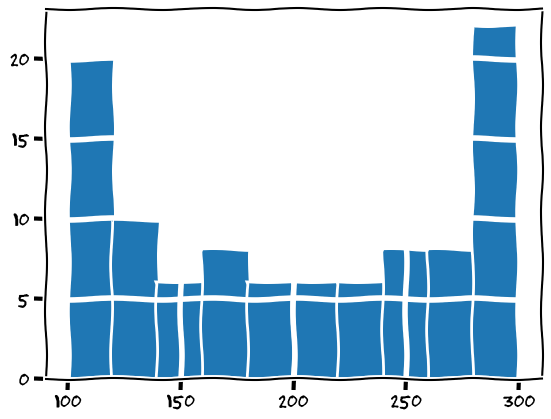

In [64]:
_ = cos_series.hist()

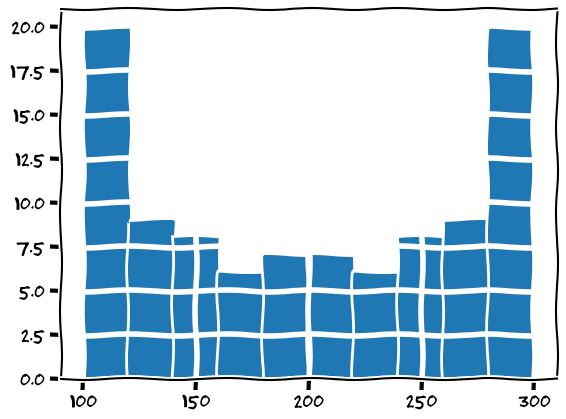

In [65]:
_ = sin_series.hist()

#### Cos Dataset

##### Offset Model 1%

In [66]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_same_cos_om1.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,1.999497,Very Acceptable
2,mse,3.997986,Very Acceptable
3,rmse,1.999497,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.008174,Very Acceptable
6,smape,0.814002,Very Acceptable
7,mbd,0.817436,Very Acceptable Overestimation


##### Offset Model 10%

In [67]:
predictions = offsetmodel_predict(cos_series, train_size, .1)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_same_cos_om10.html')

,Metric,Value,Category
0,r2,0.758015,High
1,mae,19.994965,Acceptable
2,mse,399.798642,Exceedingly High
3,rmse,19.994965,Acceptable
4,mase,5.163515,Worse Than Naive Forecast Model
5,mape,0.081744,Very Acceptable
6,smape,7.843883,Acceptable
7,mbd,8.174357,Acceptable Overestimation


#### Sin Dataset

##### AutoReg Model

In [68]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = offsetmodel_predict(sin_series, train_size)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_same_sin_om1.html')

,Metric,Value,Category
0,r2,0.996095,Very Acceptable
1,mae,1.999748,Very Acceptable
2,mse,3.998993,Very Acceptable
3,rmse,1.999748,Very Acceptable
4,mase,0.468572,Acceptable
5,mape,0.015986,Very Acceptable
6,smape,1.585355,Very Acceptable
7,mbd,1.598613,Very Acceptable Overestimation


##### Offset Model

In [69]:
predictions = offsetmodel_predict(sin_series, train_size, .1)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_same_sin_om10.html')

,Metric,Value,Category
0,r2,0.609483,Very High
1,mae,19.997483,Moderate
2,mse,399.899308,Exceedingly High
3,rmse,19.997483,Moderate
4,mase,4.685718,Worse Than Naive Forecast Model
5,mape,0.159861,Very Acceptable
6,smape,14.755368,Moderate
7,mbd,15.986130,Moderate Overestimation


### Different Magnitudes between y and yhat

Different Magnitudes between y and yhat: Investigating how metrics react when there is a noticeable scale difference between true and predicted values. (e.g., 1 vs 1000)

In [70]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
const = 21
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
y_sin = np.sin(np.linspace(0, 2 * np.pi, days)) * scale_factor + const
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']
sin_df = pd.DataFrame({'Value': y_sin})
sin_df.set_index(date_range, inplace=True)
sin_series = sin_df['Value']

In [71]:
print(cos_series.min(), cos_series.max())
print(sin_series.min(), sin_series.max())

11.00503457616815 31.0
11.00125872326125 30.99874127673875


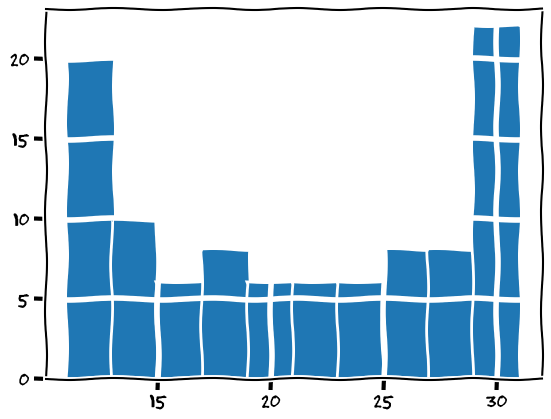

In [72]:
_ = cos_series.hist()

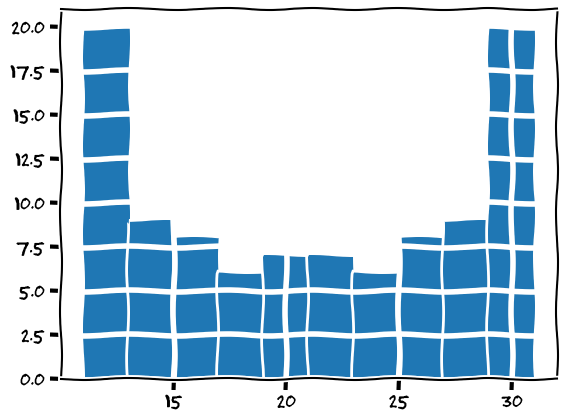

In [73]:
_ = sin_series.hist()

#### Cos Dataset

##### Offset Model 500%

In [74]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = offsetmodel_predict(cos_series, train_size, 5)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_diff_cos_om500.html')

,Metric,Value,Category
0,r2,-603.961996,Worse Than Simple Mean Model
1,mae,99.974827,Exceedingly High
2,mse,9994.966058,Exceedingly High
3,rmse,99.974827,Exceedingly High
4,mase,258.175763,Worse Than Naive Forecast Model
5,mape,3.921901,Very Acceptable
6,smape,131.636790,Exceedingly High
7,mbd,392.190141,Exceedingly High Overestimation


##### Offset Model 5000%

In [75]:
predictions = offsetmodel_predict(cos_series, train_size, 50)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_diff_cos_om5000.html')

,Metric,Value,Category
0,r2,-60495.199569,Worse Than Simple Mean Model
1,mae,999.748271,Exceedingly High
2,mse,999496.605751,Exceedingly High
3,rmse,999.748271,Exceedingly High
4,mase,2581.757631,Worse Than Naive Forecast Model
5,mape,39.219014,Very High
6,smape,190.057040,Exceedingly High
7,mbd,3921.901407,Exceedingly High Overestimation


#### Sin Dataset

##### Offset Model 500%

In [76]:
# Splitting the dataset into train and test sets
train_size = len(sin_series)-30
train, test = sin_series[:train_size], sin_series[train_size:]

predictions = offsetmodel_predict(sin_series, train_size, 5)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_diff_sin_om500.html')

,Metric,Value,Category
0,r2,-975.292444,Worse Than Simple Mean Model
1,mae,99.987413,Exceedingly High
2,mse,9997.482712,Exceedingly High
3,rmse,99.987413,Exceedingly High
4,mase,234.285887,Worse Than Naive Forecast Model
5,mape,7.377613,Acceptable
6,smape,156.158692,Exceedingly High
7,mbd,737.761265,Exceedingly High Overestimation


##### Offset Model 5000%

In [77]:
predictions = offsetmodel_predict(sin_series, train_size, 50)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/mag_diff_sin_om5000.html')

,Metric,Value,Category
0,r2,-97628.244438,Worse Than Simple Mean Model
1,mae,999.874128,Exceedingly High
2,mse,999748.271192,Exceedingly High
3,rmse,999.874128,Exceedingly High
4,mase,2342.858868,Worse Than Naive Forecast Model
5,mape,73.776127,Very High
6,smape,194.487492,Exceedingly High
7,mbd,7377.612655,Exceedingly High Overestimation


## Data Distribution and Patterns

### Trend

Trend: Examining cases where there's a consistent increase or decrease in data. (e.g., a series like 1, 2, 3, 4,...)

#### Linear Trend

In [78]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 2 * np.pi, days)
# Linear trend (Increasing and Decreasing)
y_linear_inc = 5*x + 2
y_linear_dec = -5*x + 2
linear_inc_df = pd.DataFrame({'Value': y_linear_inc})
linear_inc_df.set_index(date_range, inplace=True)
linear_inc_series = linear_inc_df['Value']
linear_dec_df = pd.DataFrame({'Value': y_linear_dec})
linear_dec_df.set_index(date_range, inplace=True)
linear_dec_series = linear_dec_df['Value']

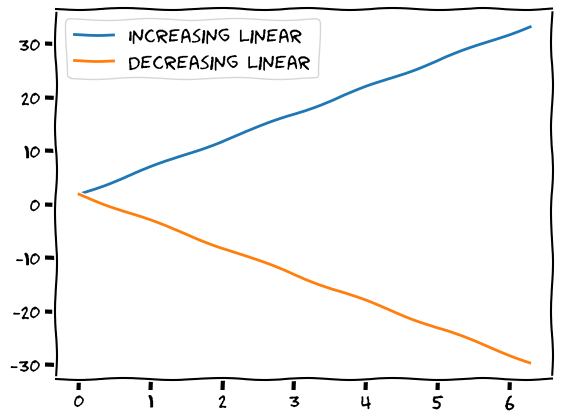

In [79]:
plt.plot(x, y_linear_inc, label='Increasing Linear')
plt.plot(x, y_linear_dec, label='Decreasing Linear')
plt.legend()
plt.show()

##### Increasing Dataset

###### AutoReg Model

In [80]:
# Splitting the dataset into train and test sets
train_size = len(linear_inc_series)-30
train, test = linear_inc_series[:train_size], linear_inc_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_lin-trend_inc_ar.html')

,Metric,Value,Category
0,r2,1.000000e+00,Perfect
1,mae,3.789561e-14,Very Acceptable
2,mse,1.566783e-27,Very Acceptable
3,rmse,3.958261e-14,Very Acceptable
4,mase,1.194192e-13,Very Acceptable
5,mape,1.292880e-15,Very Acceptable
6,smape,1.292880e-13,Very Acceptable
7,mbd,1.292880e-13,Very Acceptable Overestimation


###### Offset Model

In [81]:
predictions = offsetmodel_predict(linear_inc_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_lin-trend_inc_om.html')

,Metric,Value,Category
0,r2,0.986917,Very Acceptable
1,mae,0.314159,Very Acceptable
2,mse,0.098696,Very Acceptable
3,rmse,0.314159,Very Acceptable
4,mase,0.990000,High
5,mape,0.011003,Very Acceptable
6,smape,1.094273,Very Acceptable
7,mbd,1.100349,Very Acceptable Overestimation


##### Decreasing Dataset

###### AutoReg Model

In [82]:
# Splitting the dataset into train and test sets
train_size = len(linear_dec_series)-30
train, test = linear_dec_series[:train_size], linear_dec_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_lin-trend_dec_ar.html')

,Metric,Value,Category
0,r2,1.000000e+00,Perfect
1,mae,3.493502e-14,Very Acceptable
2,mse,1.361889e-27,Very Acceptable
3,rmse,3.690379e-14,Very Acceptable
4,mase,1.100896e-13,Very Acceptable
5,mape,1.372961e-15,Very Acceptable
6,smape,1.372961e-13,Very Acceptable
7,mbd,1.372961e-13,Very Acceptable Underestimation


###### Offset Model

In [83]:
predictions = offsetmodel_predict(linear_dec_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_lin-trend_dec_om.html')

,Metric,Value,Category
0,r2,0.986917,Very Acceptable
1,mae,0.314159,Very Acceptable
2,mse,0.098696,Very Acceptable
3,rmse,0.314159,Very Acceptable
4,mase,0.990000,High
5,mape,0.012819,Very Acceptable
6,smape,1.290262,Very Acceptable
7,mbd,-1.281887,Very Acceptable Overestimation


#### Exponential Growth / Decay

In [84]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 2 * np.pi, days)
# Exponential trend (Growth and Decay)
y_exp_growth = 2 * np.exp(0.5*x)
y_exp_decay = 2 * np.exp(0.5*(2*np.pi - x))
exp_growth_df = pd.DataFrame({'Value': y_exp_growth})
exp_growth_df.set_index(date_range, inplace=True)
exp_growth_series = exp_growth_df['Value']
exp_decay_df = pd.DataFrame({'Value': y_exp_decay})
exp_decay_df.set_index(date_range, inplace=True)
exp_decay_series = exp_decay_df['Value']

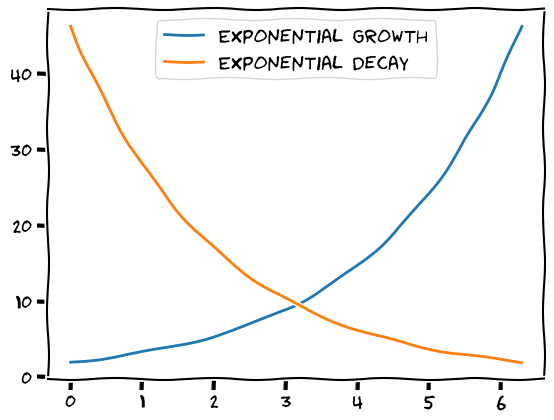

In [85]:
plt.plot(x, y_exp_growth, label='Exponential Growth')
plt.plot(x, y_exp_decay, label='Exponential Decay')
plt.legend()
plt.show()

##### Increasing Dataset

###### AutoReg Model

In [86]:
# Splitting the dataset into train and test sets
train_size = len(exp_growth_series)-30
train, test = exp_growth_series[:train_size], exp_growth_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_exp-trend_inc_ar.html')

,Metric,Value,Category
0,r2,1.000000e+00,Perfect
1,mae,1.309767e-13,Very Acceptable
2,mse,3.044372e-26,Very Acceptable
3,rmse,1.744813e-13,Very Acceptable
4,mase,5.697085e-13,Very Acceptable
5,mape,3.635550e-15,Very Acceptable
6,smape,3.635550e-13,Very Acceptable
7,mbd,-3.635550e-13,Very Acceptable Underestimation


###### Offset Model

In [87]:
predictions = offsetmodel_predict(exp_growth_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_exp-trend_inc_om.html')

,Metric,Value,Category
0,r2,0.997131,Very Acceptable
1,mae,0.442814,Very Acceptable
2,mse,0.196084,Very Acceptable
3,rmse,0.442814,Very Acceptable
4,mase,1.926104,Worse Than Naive Forecast Model
5,mape,0.015736,Very Acceptable
6,smape,1.560464,Very Acceptable
7,mbd,1.573648,Very Acceptable Overestimation


##### Decreasing Dataset

###### AutoReg Model

In [88]:
# Splitting the dataset into train and test sets
train_size = len(exp_decay_series)-30
train, test = exp_decay_series[:train_size], exp_decay_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_exp-trend_dec_ar.html')

,Metric,Value,Category
0,r2,1.000000e+00,Perfect
1,mae,1.703230e-13,Very Acceptable
2,mse,3.589584e-26,Very Acceptable
3,rmse,1.894620e-13,Very Acceptable
4,mase,2.859464e-13,Very Acceptable
5,mape,6.304709e-14,Very Acceptable
6,smape,6.304709e-12,Very Acceptable
7,mbd,6.304709e-12,Very Acceptable Overestimation


###### Offset Model

In [89]:
predictions = offsetmodel_predict(exp_decay_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_exp-trend_dec_om.html')

,Metric,Value,Category
0,r2,0.756161,High
1,mae,0.442814,Very Acceptable
2,mse,0.196084,Very Acceptable
3,rmse,0.442814,Very Acceptable
4,mase,0.743417,Moderate
5,mape,0.145083,Very Acceptable
6,smape,13.464018,Moderate
7,mbd,14.508350,Moderate Overestimation


#### Quadratic Trend

In [90]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 2 * np.pi, days)
# Quadratic trend (Upward and Downward Parabola)
y_quad_up = x**2
y_quad_down = -x**2
quad_up_df = pd.DataFrame({'Value': y_quad_up})
quad_up_df.set_index(date_range, inplace=True)
quad_up_series = quad_up_df['Value']
quad_down_df = pd.DataFrame({'Value': y_quad_down})
quad_down_df.set_index(date_range, inplace=True)
quad_down_series = quad_down_df['Value']

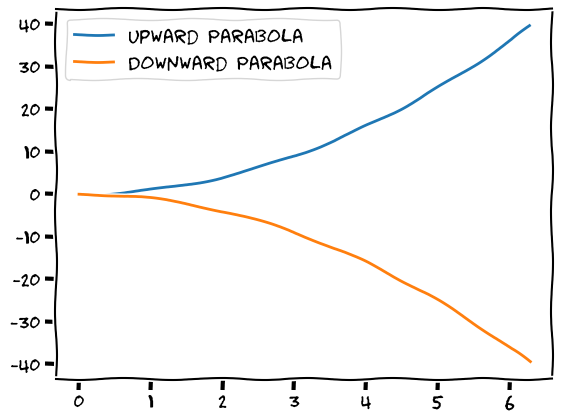

In [91]:
plt.plot(x, y_quad_up, label='Upward Parabola')
plt.plot(x, y_quad_down, label='Downward Parabola')
plt.legend()
plt.show()

##### Increasing Dataset

###### AutoReg Model

In [92]:
# Splitting the dataset into train and test sets
train_size = len(quad_up_series)-30
train, test = quad_up_series[:train_size], quad_up_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_quad-trend_inc_ar.html')

,Metric,Value,Category
0,r2,1.000000e+00,Perfect
1,mae,2.599402e-13,Very Acceptable
2,mse,9.312303e-26,Very Acceptable
3,rmse,3.051607e-13,Very Acceptable
4,mase,9.352658e-13,Very Acceptable
5,mape,8.158666e-15,Very Acceptable
6,smape,8.158666e-13,Very Acceptable
7,mbd,8.158666e-13,Very Acceptable Overestimation


###### Offset Model

In [93]:
predictions = offsetmodel_predict(quad_up_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_quad-trend_inc_om.html')

,Metric,Value,Category
0,r2,0.995520,Very Acceptable
1,mae,0.394784,Very Acceptable
2,mse,0.155855,Very Acceptable
3,rmse,0.394784,Very Acceptable
4,mase,1.420435,Worse Than Naive Forecast Model
5,mape,0.014172,Very Acceptable
6,smape,1.406851,Very Acceptable
7,mbd,1.417249,Very Acceptable Overestimation


##### Decreasing Dataset

###### AutoReg Model

In [94]:
# Splitting the dataset into train and test sets
train_size = len(quad_down_series)-30
train, test = quad_down_series[:train_size], quad_down_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_quad-trend_dec_ar.html')

,Metric,Value,Category
0,r2,1.000000e+00,Perfect
1,mae,2.599402e-13,Very Acceptable
2,mse,9.312303e-26,Very Acceptable
3,rmse,3.051607e-13,Very Acceptable
4,mase,9.352658e-13,Very Acceptable
5,mape,8.158666e-15,Very Acceptable
6,smape,8.158666e-13,Very Acceptable
7,mbd,8.158666e-13,Very Acceptable Underestimation


###### Offset Model

In [95]:
predictions = offsetmodel_predict(quad_down_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_quad-trend_dec_om.html')

,Metric,Value,Category
0,r2,0.995520,Very Acceptable
1,mae,0.394784,Very Acceptable
2,mse,0.155855,Very Acceptable
3,rmse,0.394784,Very Acceptable
4,mase,1.420435,Worse Than Naive Forecast Model
5,mape,0.014172,Very Acceptable
6,smape,1.427808,Very Acceptable
7,mbd,-1.417249,Very Acceptable Overestimation


#### Logarithmic Trend

In [96]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 2 * np.pi, days)
# Logarithmic trend (Increasing and Decreasing)
y_log_inc = 10 + 5*np.log(x+1)
y_log_dec = 10 - 5*np.log(x+1)
log_inc_df = pd.DataFrame({'Value': y_log_inc})
log_inc_df.set_index(date_range, inplace=True)
log_inc_series = log_inc_df['Value']
log_dec_df = pd.DataFrame({'Value': y_log_dec})
log_dec_df.set_index(date_range, inplace=True)
log_dec_series = log_dec_df['Value']

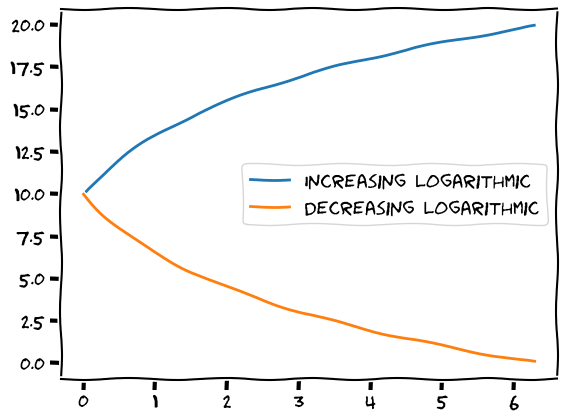

In [97]:
plt.plot(x, y_log_inc, label='Increasing Logarithmic')
plt.plot(x, y_log_dec, label='Decreasing Logarithmic')
plt.legend()
plt.show()

##### Increasing Dataset

###### AutoReg Model

In [98]:
# Splitting the dataset into train and test sets
train_size = len(log_inc_series)-30
train, test = log_inc_series[:train_size], log_inc_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_log-trend_inc_ar.html')

,Metric,Value,Category
0,r2,0.815627,Moderate
1,mae,0.155053,Very Acceptable
2,mse,0.034718,Very Acceptable
3,rmse,0.186327,Very Acceptable
4,mase,1.271729,Worse Than Naive Forecast Model
5,mape,0.007946,Very Acceptable
6,smape,0.790112,Very Acceptable
7,mbd,0.794580,Very Acceptable Overestimation


###### Offset Model

In [99]:
predictions = offsetmodel_predict(log_inc_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_log-trend_inc_om.html')

,Metric,Value,Category
0,r2,0.947657,Acceptable
1,mae,0.099278,Very Acceptable
2,mse,0.009856,Very Acceptable
3,rmse,0.099278,Very Acceptable
4,mase,0.814271,Moderate
5,mape,0.005164,Very Acceptable
6,smape,0.515103,Very Acceptable
7,mbd,0.516433,Very Acceptable Overestimation


##### Decreasing Dataset

###### AutoReg Model

In [100]:
# Splitting the dataset into train and test sets
train_size = len(log_dec_series)-30
train, test = log_dec_series[:train_size], log_dec_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_log-trend_dec_ar.html')

,Metric,Value,Category
0,r2,0.815627,Moderate
1,mae,0.155053,Very Acceptable
2,mse,0.034718,Very Acceptable
3,rmse,0.186327,Very Acceptable
4,mase,1.271729,Worse Than Naive Forecast Model
5,mape,0.600931,Very Acceptable
6,smape,59.430188,Very High
7,mbd,-60.093129,Very High Underestimation


###### Offset Model

In [101]:
predictions = offsetmodel_predict(log_dec_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_log-trend_dec_om.html')

,Metric,Value,Category
0,r2,0.947657,Acceptable
1,mae,0.099278,Very Acceptable
2,mse,0.009856,Very Acceptable
3,rmse,0.099278,Very Acceptable
4,mase,0.814271,Moderate
5,mape,0.240751,Very Acceptable
6,smape,19.392369,Moderate
7,mbd,24.075076,High Overestimation


#### Sigmoidal/Logistic Trend

In [102]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 2 * np.pi, days)
# Sigmoidal/Logistic trend (Increasing and Decreasing)
y_sigmoid_inc = 10 / (1 + np.exp(-x + 5))
y_sigmoid_dec = - 10 / (1 + np.exp(-x + 5))
sigmoid_inc_df = pd.DataFrame({'Value': y_sigmoid_inc})
sigmoid_inc_df.set_index(date_range, inplace=True)
sigmoid_inc_series = sigmoid_inc_df['Value']
sigmoid_dec_df = pd.DataFrame({'Value': y_sigmoid_dec})
sigmoid_dec_df.set_index(date_range, inplace=True)
sigmoid_dec_series = sigmoid_dec_df['Value']

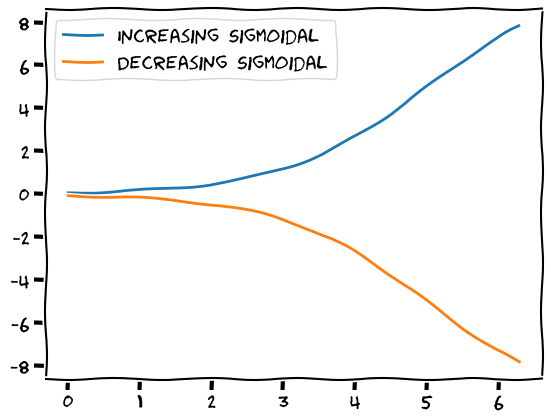

In [103]:
plt.plot(x, y_sigmoid_inc, label='Increasing Sigmoidal')
plt.plot(x, y_sigmoid_dec, label='Decreasing Sigmoidal')
plt.legend()
plt.show()

##### Increasing Dataset

###### AutoReg Model

In [104]:
# Splitting the dataset into train and test sets
train_size = len(sigmoid_inc_series)-30
train, test = sigmoid_inc_series[:train_size], sigmoid_inc_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_sigm-trend_inc_ar.html')

,Metric,Value,Category
0,r2,-0.900699,Worse Than Simple Mean Model
1,mae,1.272824,Very High
2,mse,3.108610,Very High
3,rmse,1.763125,Very High
4,mase,25.612056,Worse Than Naive Forecast Model
5,mape,0.185303,Very Acceptable
6,smape,16.058772,Moderate
7,mbd,18.530271,Moderate Overestimation


###### Offset Model

In [105]:
predictions = offsetmodel_predict(sigmoid_inc_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_sigm-trend_inc_om.html')

,Metric,Value,Category
0,r2,0.996315,Very Acceptable
1,mae,0.077630,Very Acceptable
2,mse,0.006026,Very Acceptable
3,rmse,0.077630,Very Acceptable
4,mase,1.562086,Worse Than Naive Forecast Model
5,mape,0.014016,Very Acceptable
6,smape,1.391269,Very Acceptable
7,mbd,1.401567,Very Acceptable Overestimation


##### Decreasing Dataset

###### AutoReg Model

In [106]:
# Splitting the dataset into train and test sets
train_size = len(sigmoid_dec_series)-30
train, test = sigmoid_dec_series[:train_size], sigmoid_dec_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_sigm-trend_dec_ar.html')

,Metric,Value,Category
0,r2,-0.900699,Worse Than Simple Mean Model
1,mae,1.272824,Very High
2,mse,3.108610,Very High
3,rmse,1.763125,Very High
4,mase,25.612056,Worse Than Naive Forecast Model
5,mape,0.185303,Very Acceptable
6,smape,16.058772,Moderate
7,mbd,18.530271,Moderate Underestimation


###### Offset Model

In [107]:
predictions = offsetmodel_predict(sigmoid_dec_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_sigm-trend_dec_om.html')

,Metric,Value,Category
0,r2,0.996315,Very Acceptable
1,mae,0.077630,Very Acceptable
2,mse,0.006026,Very Acceptable
3,rmse,0.077630,Very Acceptable
4,mase,1.562086,Worse Than Naive Forecast Model
5,mape,0.014016,Very Acceptable
6,smape,1.412028,Very Acceptable
7,mbd,-1.401567,Very Acceptable Overestimation


### Seasonality

Seasonality: Occurrences of regular fluctuations in data. (e.g., sinusoidal data patterns or sales spikes during the holidays)

In [108]:
# Generate a synthetic dataset
days = 365
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 2 * np.pi, days)
# Represents temperature variations over a year
y_seasonal = 20 * np.sin(4*x) + 50
seasonal_df = pd.DataFrame({'Value': y_seasonal})
seasonal_df.set_index(date_range, inplace=True)
seasonal_series = seasonal_df['Value']

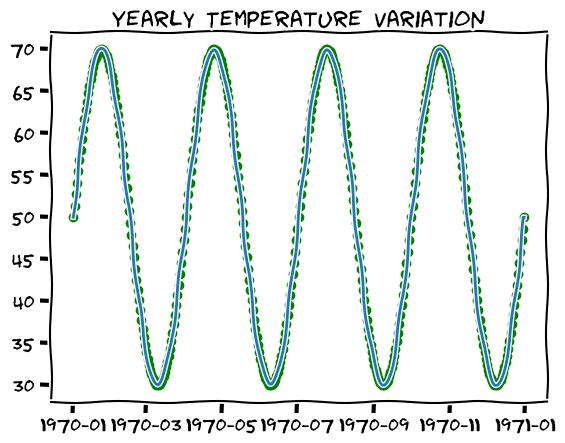

In [109]:
plt.plot(date_range, y_seasonal)
plt.scatter(date_range, y_seasonal, color='green')
plt.title('Yearly Temperature Variation')
plt.show()

#### AutoReg Model

In [110]:
# Splitting the dataset into train and test sets
train_size = len(seasonal_series)-30
train, test = seasonal_series[:train_size], seasonal_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_seasonality_ar.html')

,Metric,Value,Category
0,r2,-2.067862,Worse Than Simple Mean Model
1,mae,7.713875,Moderate
2,mse,121.802076,Exceedingly High
3,rmse,11.036398,High
4,mase,8.660157,Worse Than Naive Forecast Model
5,mape,0.185327,Very Acceptable
6,smape,22.403133,High
7,mbd,-17.080729,Moderate Underestimation


#### Offset Model

In [111]:
predictions = offsetmodel_predict(seasonal_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_seasonality_om.html')

,Metric,Value,Category
0,r2,0.995971,Very Acceptable
1,mae,0.399940,Very Acceptable
2,mse,0.159952,Very Acceptable
3,rmse,0.399940,Very Acceptable
4,mase,0.449002,Acceptable
5,mape,0.011416,Very Acceptable
6,smape,1.134969,Very Acceptable
7,mbd,1.141604,Very Acceptable Overestimation


### Outliers

Outliers: Situations where there are extreme values that might disproportionately affect metrics. (e.g., series like 1, 2, 3, 1000, 5)

In [112]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.linspace(0, 4 * np.pi, days)
y = np.sin(x)
y_extreme = np.where(np.abs(y) > .99, 1000 * y, y)
extreme_df = pd.DataFrame({'Value': y_extreme})
extreme_df.set_index(date_range, inplace=True)
extreme_series = extreme_df['Value']

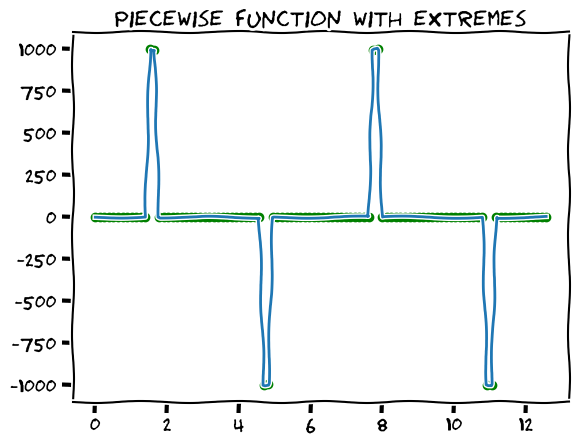

In [113]:
plt.plot(x, y_extreme)
plt.scatter(x, y_extreme, color='green')
plt.title('Piecewise function with extremes')
plt.show()

#### AutoReg Model

In [114]:
# Splitting the dataset into train and test sets
train_size = len(extreme_series)-40
train, test = extreme_series[:train_size], extreme_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_outliers_ar.html')

,Metric,Value,Category
0,r2,-1.226737e-01,Worse Than Simple Mean Model
1,mae,2.233698e+02,Moderate
2,mse,1.116761e+05,Exceedingly High
3,rmse,3.341798e+02,Moderate
4,mase,3.296009e+00,Worse Than Naive Forecast Model
5,mape,1.015529e+16,Exceedingly High
6,smape,1.963505e+02,Exceedingly High
7,mbd,-4.974683e+12,Exceedingly High Underestimation


#### Offset Model

In [115]:
predictions = offsetmodel_predict(extreme_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_outliers_om.html')

,Metric,Value,Category
0,r2,9.959798e-01,Very Acceptable
1,mae,1.999748e+01,Very Acceptable
2,mse,3.998993e+02,High
3,rmse,1.999748e+01,Very Acceptable
4,mase,2.950796e-01,Acceptable
5,mape,1.020574e+15,Exceedingly High
6,smape,1.763867e+02,Exceedingly High
7,mbd,4.999395e+11,Exceedingly High Overestimation


### Repeated Patterns

Repeated Patterns: Situations where certain patterns in the data repeat after regular intervals. (e.g., a daily temperature dataset that consistently peaks at midday and dips at midnight like 1, 2, 3, 1, 2, 3, 1, 2, 3....)

In [116]:
# Generate a synthetic dataset
days = 100
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
x = np.arange(0, days)
y_repeated = np.array([repeated_pattern(i) for i in x])
repeated_df = pd.DataFrame({'Value': y_repeated})
repeated_df.set_index(date_range, inplace=True)
repeated_series = repeated_df['Value']

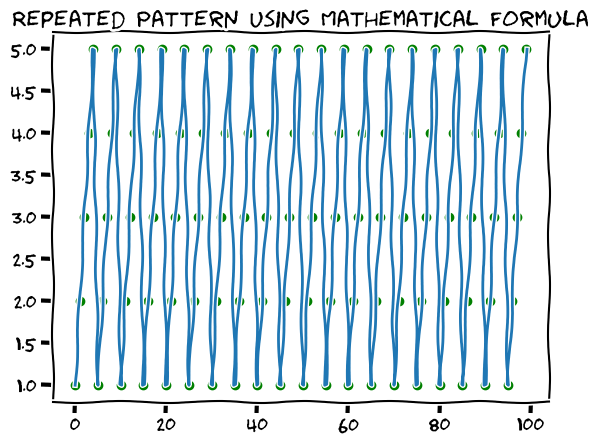

In [117]:
plt.plot(x, y_repeated)
plt.scatter(x, y_repeated, color='green')
plt.title('Repeated Pattern Using Mathematical Formula')
plt.show()

#### AutoReg Model

In [118]:
# Splitting the dataset into train and test sets
train_size = len(repeated_series)-40
train, test = repeated_series[:train_size], repeated_series[train_size:]

predictions = autoreg_predict(train, test)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_repeated_ar.html')

,Metric,Value,Category
0,r2,-0.019223,Worse Than Simple Mean Model
1,mae,1.239337,Very High
2,mse,2.038446,Very High
3,rmse,1.427742,Very High
4,mase,0.794792,Moderate
5,mape,0.687385,Very Acceptable
6,smape,44.661671,Very High
7,mbd,46.604283,Very High Overestimation


#### Offset Model

In [119]:
predictions = offsetmodel_predict(repeated_series, train_size)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/ddp_repeated_om.html')

,Metric,Value,Category
0,r2,0.999200,Very Acceptable
1,mae,0.040000,Very Acceptable
2,mse,0.001600,Very Acceptable
3,rmse,0.040000,Very Acceptable
4,mase,0.025652,Very Acceptable
5,mape,0.018267,Very Acceptable
6,smape,1.803622,Very Acceptable
7,mbd,1.826667,Very Acceptable Overestimation


## Nature of errors

### Systematic overestimation

Systematic overestimation: When predictions are consistently higher than true values. (e.g., true: 1, 2, 3; predicted: 3, 4, 5)

In [120]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']

#### Offset Model 1%

In [121]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = offsetmodel_predict(cos_series, train_size)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/err_overestimation_om1.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,0.199950,Very Acceptable
2,mse,0.039980,Very Acceptable
3,rmse,0.199950,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.108828,Very Acceptable
6,smape,13.169211,Moderate
7,mbd,-1.288577,Very Acceptable Overestimation


#### Offset Model 10%

In [122]:
predictions = offsetmodel_predict(cos_series, train_size, .1)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/err_overestimation_om10.html')

,Metric,Value,Category
0,r2,0.758015,High
1,mae,1.999497,Acceptable
2,mse,3.997986,Moderate
3,rmse,1.999497,Acceptable
4,mase,5.163515,Worse Than Naive Forecast Model
5,mape,1.088280,Very Acceptable
6,smape,60.586083,Very High
7,mbd,-12.885775,Moderate Overestimation


### Systematic underestimation

Systematic underestimation: When predictions are consistently lower than true values. (e.g., true: 3, 4, 5; predicted: 1, 2, 3)

In [123]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']

#### Offset Model 1%

In [124]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = negoffsetmodel_predict(cos_series, train_size)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/err_underestimation_om1.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,0.199950,Very Acceptable
2,mse,0.039980,Very Acceptable
3,rmse,0.199950,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.108828,Very Acceptable
6,smape,9.616990,Acceptable
7,mbd,1.288577,Very Acceptable Underestimation


#### Offset Model 10%

In [125]:
predictions = negoffsetmodel_predict(cos_series, train_size, .1)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/err_underestimation_om10.html')

,Metric,Value,Category
0,r2,0.758015,High
1,mae,1.999497,Acceptable
2,mse,3.997986,Moderate
3,rmse,1.999497,Moderate
4,mase,5.163515,Worse Than Naive Forecast Model
5,mape,1.088280,Very Acceptable
6,smape,67.322144,Very High
7,mbd,12.885775,Moderate Underestimation


### Random errors

Random errors: Unpredictable error patterns where predictions sometimes overshoot and sometimes undershoot the true values and none of the predicted values exactly match the true values. (e.g., for a true sequence of 1, 2, 3, 4, 5, a prediction might be 2, 1.5, 4, 3.5, 5.5)

In [126]:
# Generate a synthetic dataset
days = 100
scale_factor = 10
date_range = pd.date_range(datetime(1970, 1, 1), periods=days)
y_cos = np.cos(np.linspace(0, 2 * np.pi, days)) * scale_factor
cos_df = pd.DataFrame({'Value': y_cos})
cos_df.set_index(date_range, inplace=True)
cos_series = cos_df['Value']

#### RandomOffset Model 1%

In [127]:
# Splitting the dataset into train and test sets
train_size = len(cos_series)-30
train, test = cos_series[:train_size], cos_series[train_size:]

predictions = randomoffsetmodel_predict(cos_series, train_size)

# Calculate metrics
y_max, y_min = train.max(), train.min()
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/err_random_om1.html')

,Metric,Value,Category
0,r2,0.997580,Very Acceptable
1,mae,0.199950,Very Acceptable
2,mse,0.039980,Very Acceptable
3,rmse,0.199950,Very Acceptable
4,mase,0.516352,Moderate
5,mape,0.108828,Very Acceptable
6,smape,9.488976,Acceptable
7,mbd,4.961370,Very Acceptable Overestimation


#### RandomOffset Model 10%

In [128]:
predictions = randomoffsetmodel_predict(cos_series, train_size, .1)

# Calculate metrics
display_metrics(test, predictions, train, y_max, y_min)

# Visualization using plotly
# display_forecast_plotly(train, test, predictions)
# or Save visualization using Plotly as HTML file
save_forecast_plotly(train, test, predictions, 'plots/err_random_om10.html')

,Metric,Value,Category
0,r2,0.758015,High
1,mae,1.999497,Acceptable
2,mse,3.997986,Moderate
3,rmse,1.999497,Acceptable
4,mase,5.163515,Worse Than Naive Forecast Model
5,mape,1.088280,Very Acceptable
6,smape,54.336657,Very High
7,mbd,-25.911287,High Overestimation
